In [48]:
# Numerical computation and visualization libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Pytorch Libraries
import torch
import torchvision
import torchvision.transforms as tr
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim
from torchvision import models
import copy

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [50]:
# Dataset 

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      #transform=tr.ToTensor()
                                      )


testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     #transform=tr.ToTensor()
                                    )

print('Len of train dataset ',len(trainset))
print('Len of test dataset ',len(testset))
print('-'*30)
print(trainset)
print(testset)
print('-'*30)
print(trainset[0])
print(testset[0])
print('-'*30)
trainset[0][0]

Len of train dataset  60000
Len of test dataset  10000
------------------------------
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
------------------------------
(<PIL.Image.Image image mode=L size=28x28 at 0x7FEA2FCD6350>, 5)
(<PIL.Image.Image image mode=L size=28x28 at 0x7FEA2FCD6190>, 7)
------------------------------


Label : 9


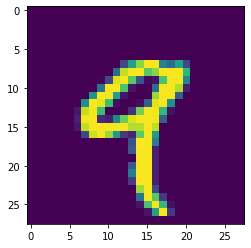

In [51]:
# Loading images and labels for fifth item dataitem

image , label = trainset[4]
plt.imshow(image)
print('Label :',label)

In [52]:
#Converting the Dataset into tensors

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=tr.ToTensor()
                                      )


testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=tr.ToTensor()
                                    )

In [53]:
# Split the data into train and validation set

trainset , valset = random_split(trainset,[50000,10000])
len(trainset),len(valset)

(50000, 10000)

In [54]:
batch_size= 128

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset,
                                          batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=batch_size,
                                          shuffle=False)

classes = ('0','1','2','3','4','5','6','7','8','9')

In [55]:
images , labels= next(iter(trainloader))
print(images.shape)
print(images[1].shape)
print(labels[1].item())

plt.figure(figsize=(8,8))
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
    
# imshow(torchvision.utils.make_grid(images))

torch.Size([128, 1, 28, 28])
torch.Size([1, 28, 28])
7


<Figure size 576x576 with 0 Axes>

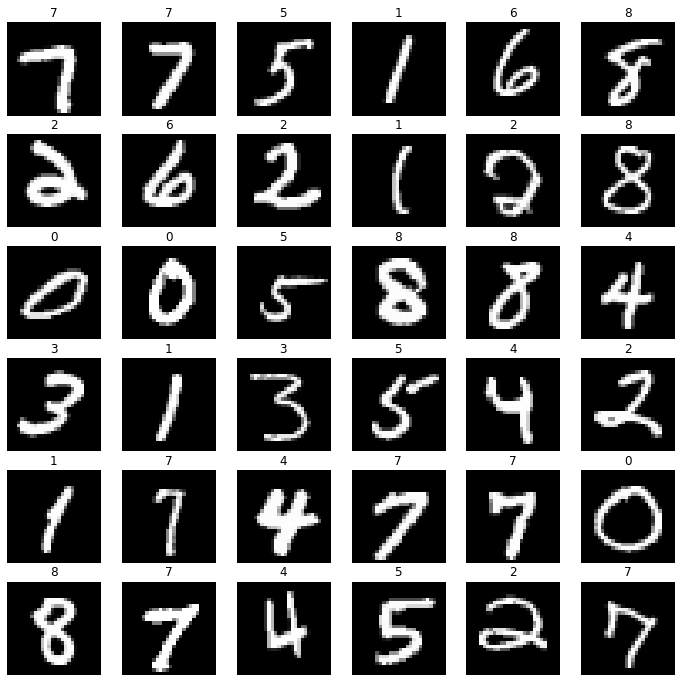

In [56]:
# Plotting images 

plt.figure(figsize=(12,12))
plt.subplot(321)
for i in range(36):
    ax1 = plt.subplot(6,6,i+1)
    plt.imshow(images[i+1].reshape(28,28).detach().numpy(),cmap='gray')
    plt.title(labels[i+1].item())
    plt.axis('off')
plt.show()

## Let's Train LeNET

In [57]:
 # Defining a custom LeNet module

class LeNet(nn.Module):                         # Extending nn.Module class 
    def __init__(self):                         # Constructor 
        super(LeNet,self).__init__()            # Calls the constructor of nn.Module
        self.cnn_model = nn.Sequential(         # nn.Sequentila allows multiple layers to stack together
            nn.Conv2d(1,6,5),                   #(N,1,28,28) -> (N,6,24,24)
            nn.Tanh(),                      
            nn.AvgPool2d(2,stride=2),           #(N,6,24,24) -> (N,6,12,12)
            nn.Conv2d(6,16,5),                  #(N,6,12,12) -> (N,16,8,8)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2)            #(N,16,8,8) -> (N,16,4,4)
            )
        
        self.fc_model = nn.Sequential(          # Fully connected layer 
            nn.Linear(256,120),
            nn.Tanh(),
            nn.Linear(120,84),
            nn.Tanh(),
            nn.Linear(84,10)
        
            )
        
# It get a batch of data which have defined earlier 
        
    def forward(self,x):     
        #print(x.shape)
        x = self.cnn_model(x)       
        #print(x.shape)
        x = x.view(x.size(0),-1)    # Flatning the inputs from tensors to vectors 
        #print(x.shape)
        x = self.fc_model(x)        # Passing the conv layer to fully connected layer
        #print(x.shape)
        return x
    
net = LeNet()#.to(device)
net

LeNet(
  (cnn_model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [58]:
print(net.fc_model[4].weight.shape,net.fc_model[4].bias.shape)
#list(net.parameters())

torch.Size([10, 84]) torch.Size([10])


In [59]:
# Evaluate on the basics of accuracy

def evaluation(dataloader):
    total , correct = 0,0
    for data in dataloader:
        inputs , labels = data
        inputs , labels = inputs.to(device) , labels.to(device)
        output = net(inputs)            
        max_pred,pred = torch.max(output.data,dim=1)
        total +=labels.size(0)
        correct +=(pred == labels).sum().item()  
    return 100 * correct / total

In [60]:
net = LeNet().to(device)           # Creating object for LeNet() model and passing it to GPU 

loss_fn = nn.CrossEntropyLoss()    # It takes the highest value which is the predictions and mark it as 1
                                   # And mark rest of the values as zeros. 
opt = optim.Adam(net.parameters()) # Using adam Optimization algorithm , we can also specify the hyperparameters .

In [ ]:
# Fit the model and perform the training process 

%time
def fit(max_epochs =16):
    
    loss_arr = []
    loss_epoch_arr = []
    
    for epoch in range(max_epochs):
        for i, data in enumerate(trainloader,0): # Iterating through the train loader 
            inputs,labels = data
            inputs,labels = inputs.to(device),labels.to(device)

            opt.zero_grad()     # Reset the gradient in every iteration

            outputs = net(inputs)
            loss = loss_fn(outputs,labels)   # Loss forward pass
            loss.backward()                  # Loss backaed pass
            opt.step()                       # Update all the parameters by the given learnig rule

            loss_arr.append(loss.item())
        loss_epoch_arr.append(loss.item())
        print('Val accuracy: %0.2f , Train accuracy : %0.2f'%(evaluation(valloader),evaluation(trainloader)))

    plt.plot(loss_epoch_arr)
    plt.show()
    
fit()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Val accuracy: 94.23 , Train accuracy : 94.51
Val accuracy: 96.64 , Train accuracy : 96.79
Val accuracy: 97.48 , Train accuracy : 97.91
Val accuracy: 97.91 , Train accuracy : 98.45
Val accuracy: 97.89 , Train accuracy : 98.48
Val accuracy: 98.07 , Train accuracy : 98.86
Val accuracy: 98.09 , Train accuracy : 99.02
Val accuracy: 98.51 , Train accuracy : 99.29
Val accuracy: 98.22 , Train accuracy : 99.10
Val accuracy: 98.52 , Train accuracy : 99.45
Val accuracy: 98.49 , Train accuracy : 99.49
Val accuracy: 98.45 , Train accuracy : 99.60
Val accuracy: 98.53 , Train accuracy : 99.60
Val accuracy: 98.64 , Train accuracy : 99.67


In [ ]:
# Here we are visualiizing the behaviour of image in the first layer () of LeNet Architecture 

net = net.to('cpu')                    # Taking the model back to the CPU 
out = net.cnn_model[0](images)
print('Image Shape :',out.shape)
image_id = 3

plt.figure(figsize=(6,6))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3,2,i+1)
    plt.imshow(out[image_id,i,:,:].detach().numpy(),cmap='gray')
plt.show()

In [ ]:
img , label = testset[0]
plt.imshow(img[0],cmap='gray')
print('Shape :',img.shape)
print('Label :',label)
print(img.unsqueeze(0).shape)

# img.unsqueeze simply adds another dimension at the begining of the 1x28x28 
# tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

In [35]:
# Function which loads the prediction of our model

def predict_image(img,model):
    xb = img.unsqueeze(0)
    yb = net(xb)
    _,pred = torch.max(yb,dim=1)
    return pred[0].item()

Actual : 9 Predicted: 9


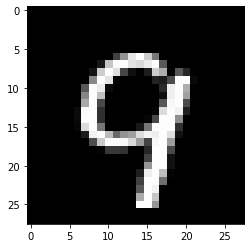

In [38]:
img , label = testset[16]
plt.imshow(img[0],cmap='gray')
print('Actual :',label,'Predicted:',predict_image(img,net))

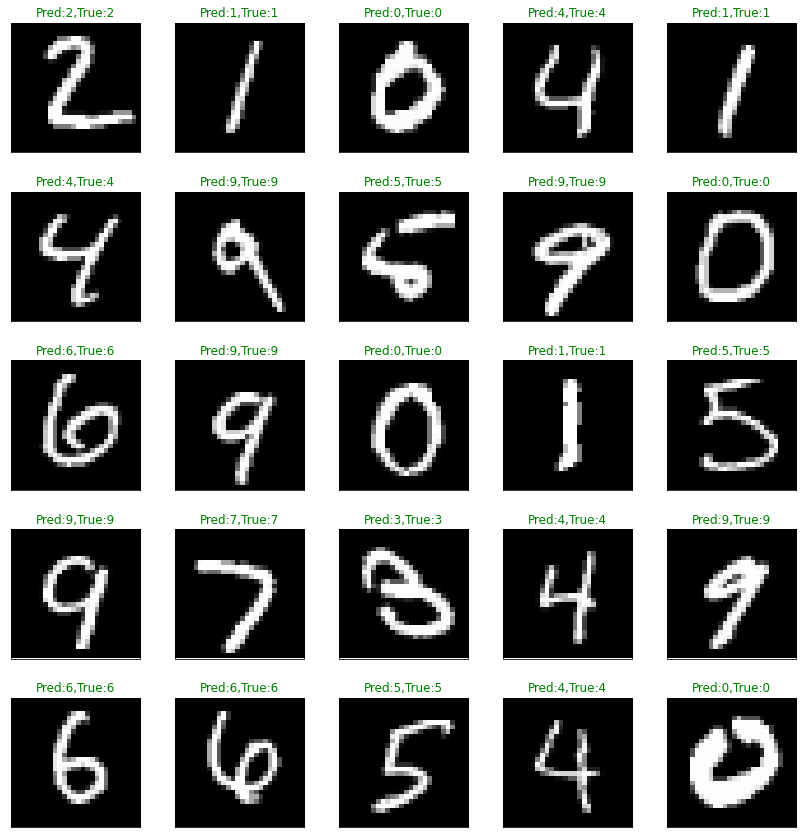

In [39]:
# Function which loads the prediction of our model

def predict_image(img,model):              # Here we are giving an input  tensor
    xb = img.unsqueeze(0)                  # Adding another dimention because our model accepts a bath
    yb = net(xb)                           # Passing the bacth into the model
    _,pred = torch.max(yb,dim=1)           # Getting the prediction from output (_ : will give the max prob and prob : will give the index of highest prob)              
    return pred[0].item()

# View the actual label and prediction of our model

plt.figure(figsize=(12,12))
plt.subplot(321)
for i in range(25):
    ax1 = plt.subplot(5,5,i+1)
    img , label = testset[i+1]
    plt.imshow(img[0],cmap='gray')
    if predict_image(img,net) == label:
        color = 'green'
    else:
        color = 'red'
    
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=2)
    plt.title('Pred:{},True:{}'.format(predict_image(img,net),label),color=color)
plt.show()

# Tensorflow Prediction

In [16]:
import numpy as np
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
#Dropout use for prevent our model to overfitting

from keras.models import Sequential


In [6]:
#mnist.load_data()

In [7]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train.shape, y_train.shape , x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

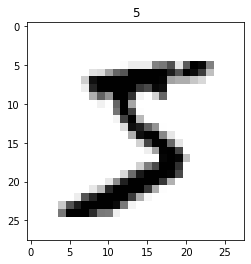

In [8]:
def plot_input_img(i):
  plt.imshow(x_train[i], cmap='binary')
  plt.title(y_train[i])
  plt.show()
plot_input_img(0)

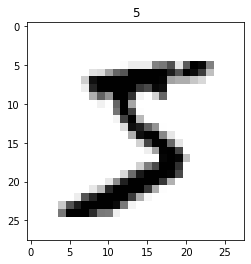

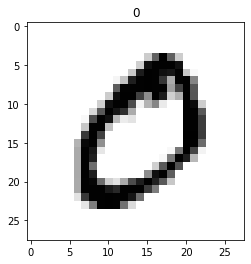

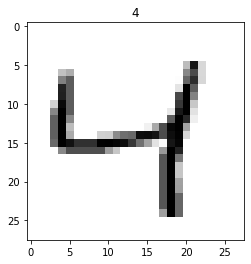

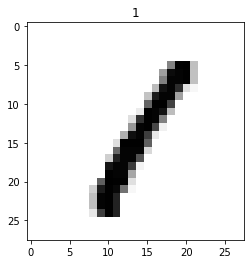

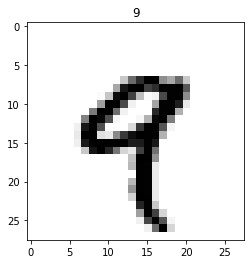

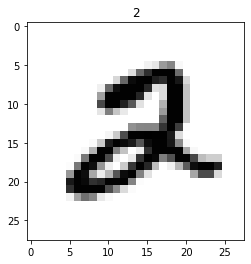

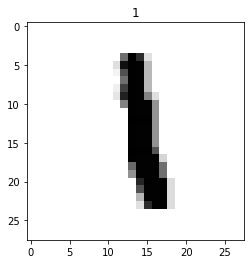

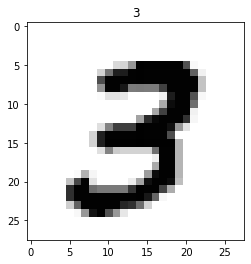

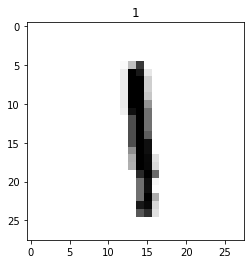

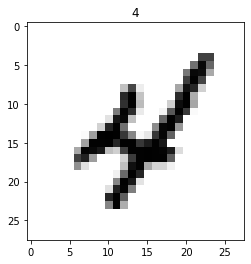

In [9]:
for i in range(10):
  plot_input_img(i)

In [10]:
# Let's Preprocess the images

# #Normilaizing the image
# x_train = x_train.astype(np.float32)/255
# x_test = x_test.astype(np.float32)/255



In [11]:

x_train.shape

(60000, 28, 28)

In [12]:
# Let's Preprocess the images
from tensorflow.keras.utils import to_categorical
#Normilaizing the image
x_train = x_train.astype(np.float32)/255
x_test = x_test.astype(np.float32)/255

#Reshape / expand the dimention of the images to (28,28,1)
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)

#converting label to one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
x_train.shape

(60000, 28, 28, 1)

#### The LeNet architecture we will apply is as follows:

INPUT => CONV (28x28x20, f = 5, s = 1) => RELU => POOL (14x14x20, f = 2, s = 2) => CONV (14x14x50, f = 5, s = 1) => RELU => POOL (7x7x50, f = 2, s = 2) + flatten => FC (120) => RELU => FC (84) => softmax

Thus, there are 2 conv layers and 2 pooling layers. Then 2 fully connected layers with ReLU activation and the final layer with a softmax

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=784, activation='relu', input_shape=(784, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=392, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=151, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10, activation='softmax'),
])

In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 48)          13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 48)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 48)          0

In [23]:
model.compile(optimizer='Adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [24]:
from numpy.lib.npyio import savez_compressed
# callback

from keras.callbacks import EarlyStopping, ModelCheckpoint

#Early stopping
es = EarlyStopping(monitor = 'val_acc', min_delta =0.01, patience=4, verbose=1)

#Model check pOINT
mc = ModelCheckpoint("./BESTMODEL.h5", monitor = 'val_acc', verbose = 1,save_best_only = True )
cb = [es,mc]

In [25]:
history = model.fit(x_train,y_train, epochs = 50,validation_split=0.3)

Epoch 1/50
1313/1313 [==============================] - 13s 9ms/step - loss: 0.3849 - accuracy: 0.8772 - val_loss: 0.0920 - val_accuracy: 0.9729
Epoch 2/50
1313/1313 [==============================] - 11s 8ms/step - loss: 0.1306 - accuracy: 0.9652 - val_loss: 0.0663 - val_accuracy: 0.9809
Epoch 3/50
1313/1313 [==============================] - 12s 9ms/step - loss: 0.1005 - accuracy: 0.9723 - val_loss: 0.0569 - val_accuracy: 0.9848
Epoch 4/50
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0848 - accuracy: 0.9766 - val_loss: 0.0445 - val_accuracy: 0.9879
Epoch 5/50
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0855 - accuracy: 0.9780 - val_loss: 0.0448 - val_accuracy: 0.9879
Epoch 6/50
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0728 - accuracy: 0.9806 - val_loss: 0.0459 - val_accuracy: 0.9882
Epoch 7/50
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0716 - accuracy: 0.9811 - val_loss: 0.0418 - val_ac

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

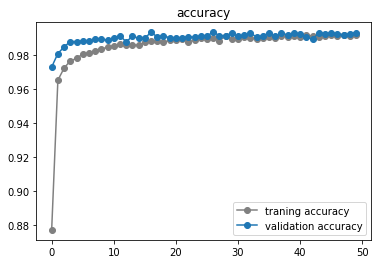

In [28]:

plt.title('accuracy')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], c='gray', marker='o')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], marker='o')
plt.legend(labels=['traning accuracy', 'validation accuracy'])
plt.show()

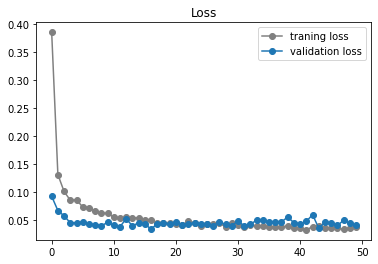

In [30]:
plt.title('Loss')
plt.plot(range(len(history.history['loss'])), history.history['loss'], marker='o', c='gray')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], marker='o')
plt.legend(labels=['traning loss', 'validation loss'])
plt.show()

In [31]:
model.evaluate(x_train,y_train)

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0141 - accuracy: 0.9972


[0.014140607789158821, 0.9972000122070312]

In [38]:
!mkdir -p saved_model
model.save('saved_model/tensor_lenetmodel.h5') 
!ls saved_model

tensor_lenetmodel  tensor_lenetmodel.h5  torch_lenetmodel
